<a href="https://colab.research.google.com/github/putopavel/practical-application-sentiment-analysis-deep-learning/blob/master/svm_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet texthero
    from google.colab import drive
    import os
    # This will prompt for authorization.
    drive.mount('/content/drive')
    drive_path = "/content/drive/My Drive/TFM"
    os.chdir(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import texthero as hero
from texthero import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [13]:
def preprocess_tweets(df):
    custom_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_urls,
        preprocessing.remove_digits,
        preprocessing.remove_punctuation,
        preprocessing.remove_whitespace,
    ]
    df["CLEAN_TWEET"] = df.TWEET.pipe(hero.clean, custom_pipeline)


def preprocess_file(input_filename):
    df = pd.read_csv(input_filename, sep="\t")
    preprocess_tweets(df)
    return df

In [14]:
def fit_dataset(df, test_len):
    feature_extraction = TfidfVectorizer()
    X = feature_extraction.fit_transform(df.CLEAN_TWEET)
    y = df.LABEL.to_numpy()
    X_train, X_test = X[:-test_len], X[-test_len:]
    y_train, y_test = y[:-test_len], y[-test_len:]
    param_grid = {
        "C": [0.1, 1, 10, 100],
        "gamma": [1, 0.1, 0.01],
        "kernel": ["rbf", "linear"]
    }
    grid = GridSearchCV(SVC(), param_grid, verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid, X_test

# Spanish Dataset

In [15]:
spanish_train = preprocess_file("spanish_train.csv")
spanish_val = preprocess_file("spanish_val.csv")
spanish_test = preprocess_file("spanish_test.csv")
spanish_full_df = pd.concat((spanish_train, spanish_val, spanish_test))

In [16]:
%%timeit -r 1 -n 1
spanish_grid, spanish_X_test = fit_dataset(spanish_full_df, len(spanish_test))
spanish_test["PRED_LABEL"] = spanish_grid.predict(spanish_X_test)
print(classification_report(spanish_test["LABEL"], spanish_test["PRED_LABEL"]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 30.1min finished


              precision    recall  f1-score   support

     AGAINST       0.73      0.76      0.74       829
       FAVOR       0.72      0.74      0.73       807
     NEUTRAL       0.92      0.76      0.83       380

    accuracy                           0.75      2016
   macro avg       0.79      0.75      0.77      2016
weighted avg       0.76      0.75      0.75      2016

1 loop, best of 1: 30min 41s per loop


# Catalan dataset

In [17]:
catalan_train = preprocess_file("catalan_train.csv")
catalan_val = preprocess_file("catalan_val.csv")
catalan_test = preprocess_file("catalan_test.csv")
catalan_full_df = pd.concat((catalan_train, catalan_val, catalan_test))

In [18]:
%%timeit -r 1 -n 1
catalan_grid, catalan_X_test = fit_dataset(catalan_full_df, len(catalan_test))
catalan_test["PRED_LABEL"] = catalan_grid.predict(catalan_X_test)
print(classification_report(catalan_test["LABEL"], catalan_test["PRED_LABEL"]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 28.6min finished


              precision    recall  f1-score   support

     AGAINST       0.67      0.78      0.72       752
       FAVOR       0.75      0.77      0.76       804
     NEUTRAL       0.78      0.53      0.63       454

    accuracy                           0.72      2010
   macro avg       0.73      0.69      0.70      2010
weighted avg       0.73      0.72      0.72      2010

1 loop, best of 1: 29min 3s per loop


# Combined dataset

In [19]:
combined_train = pd.concat((spanish_train, catalan_train))
combined_val = pd.concat((spanish_val, catalan_val))
combined_test = pd.concat((spanish_test, catalan_test))
combined_full_df = pd.concat((combined_train, combined_val, combined_test))

In [31]:
%%timeit -r 1 -n 1
combined_grid, combined_X_test = fit_dataset(combined_full_df, len(combined_test))
combined_test["PRED_LABEL"] = combined_grid.predict(combined_X_test)
print(classification_report(combined_test["LABEL"], combined_test["PRED_LABEL"]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 198.5min finished


              precision    recall  f1-score   support

     AGAINST       0.68      0.73      0.71      1581
       FAVOR       0.71      0.73      0.72      1611
     NEUTRAL       0.81      0.67      0.73       834

    accuracy                           0.71      4026
   macro avg       0.73      0.71      0.72      4026
weighted avg       0.72      0.71      0.71      4026

1 loop, best of 1: 3h 23min 12s per loop


# Confusion Matrices

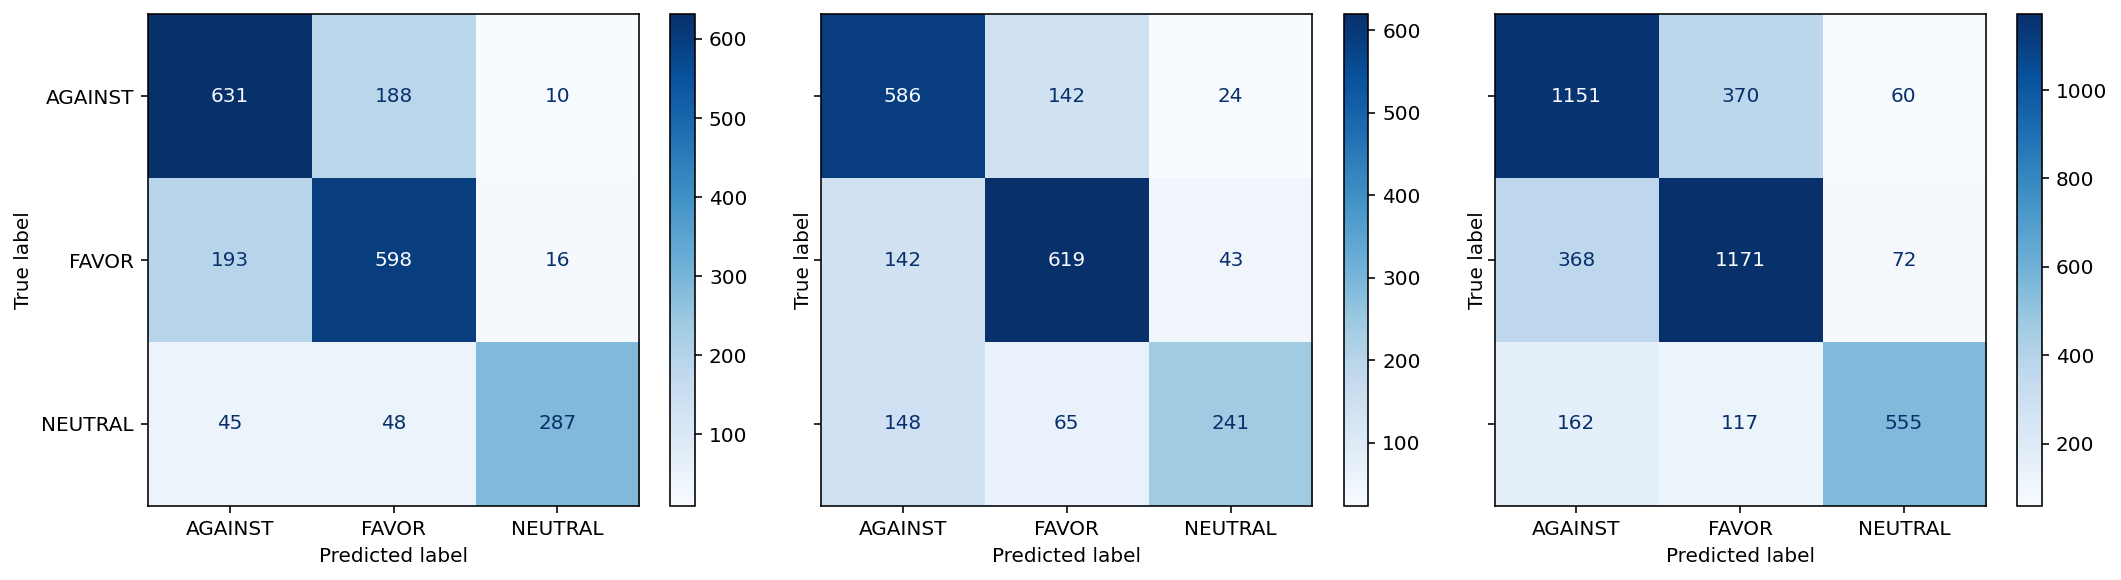

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

cf = confusion_matrix(spanish_test.LABEL, spanish_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, spanish_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[0], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(catalan_test.LABEL, catalan_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, catalan_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[1], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(combined_test.LABEL, combined_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, combined_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[2], xticks_rotation="horizontal", values_format="d")

fig.tight_layout()